# 季節調整項

In [1]:
%matplotlib inline

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pystan import StanModel

plt.rcParams['figure.figsize'] = (20, 12)

In [3]:
stan_code = """
data {
    int T;
    vector[T] Y;
}

parameters {
    vector[T] mu;
    vector[T] season;
    real<lower=0> s_mu;
    real<lower=0> s_season;
    real<lower=0> s_Y;
}
transformed parameters {
    vector[T] y_mean;
    y_mean = mu + season;
}

model {
    mu[2:T] ~ normal(mu[1:(T-1)],s_mu);
    for(t in 7:T)
        season[t] ~ normal(-sum(season[(t-6):(t-1)]),s_season);
    Y ~ normal(y_mean,s_Y);
}

"""

In [34]:

y=np.random.normal(3,1,size=100)
for i in range(100):
    if (i+3) % 7 == 0:
        y[i] += 10

stan_dat = {
    'T': 100,
    'Y': y
}

sm = StanModel(model_code=stan_code)
fit = sm.sampling(data=stan_dat, iter = 2500, chains = 4)

# save it to the file 'model.pkl' for later use
with open('model.pkl', 'wb') as f:
    pickle.dump(sm, f)
    
ms=fit.extract()

In [6]:
N=100
y=np.random.normal(3,1,size=N) + np.linspace(0,10,N)
for i in range(N):
    if (i+2) % 7 == 0:
        y[i] += i
    
    if (i+5) % 7 == 0:
        y[i] -= i
        
stan_dat = {
    'T': N,
    'Y': y
}
sm = pickle.load(open('model.pkl', 'rb'))
fit = sm.sampling(data=stan_dat, iter = 2500, chains = 4)
ms=fit.extract()

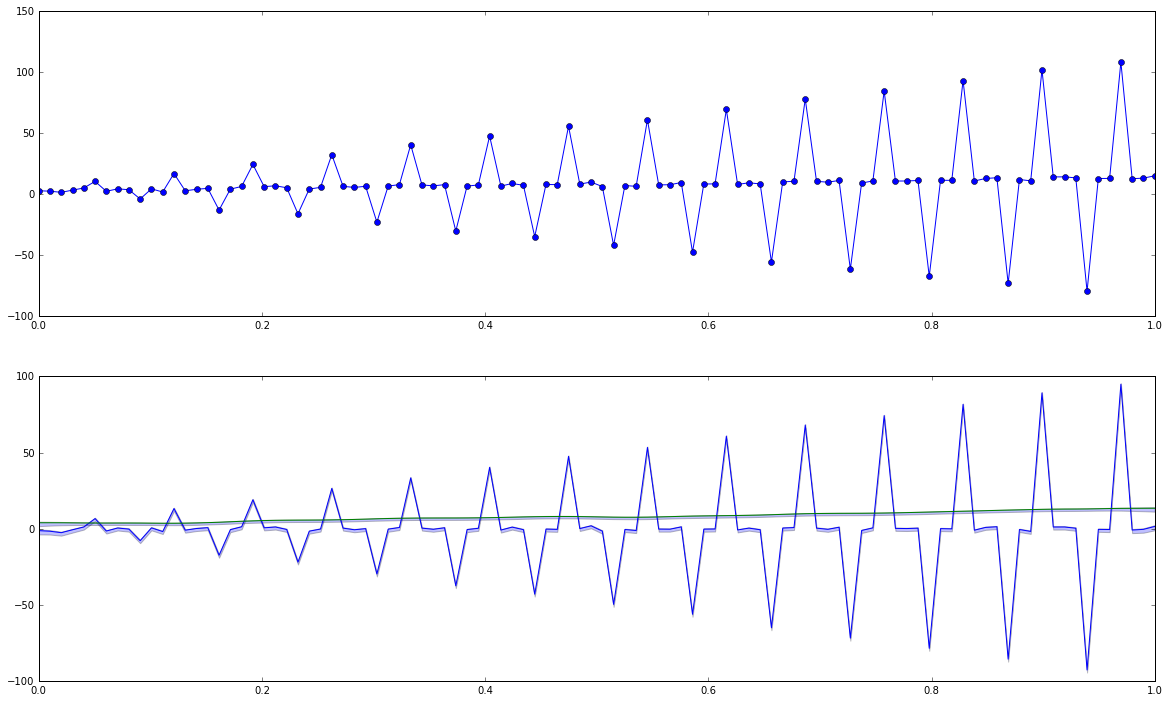

In [7]:
t=np.linspace(0,1,len(y))
plt.subplot(2,1,1)
plt.plot(t,y,"bo-")
plt.subplot(2,1,2)
season_mean=np.mean(ms["season"],axis=0)
season_std=np.std(ms["season"],axis=0)
plt.plot(t,season_mean)
plt.fill_between(t,season_mean - season_std*3,season_mean +season_std,alpha=0.25)


mu_mean=np.mean(ms["mu"],axis=0)
mu_std=np.std(ms["mu"],axis=0)
plt.plot(t,mu_mean)
plt.fill_between(t,mu_mean - mu_std*3,mu_mean +mu_std,alpha=0.25)
